<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/final_model_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 合并 HFI 到建模数据表

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [3]:
# ==== 2. 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [4]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [5]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [6]:
# 导出合并后的数据
df_model.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx", index=False)

print("已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx")


已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx


# 0. 准备：工具函数

In [13]:
# =============================================
# ============  Imports & Settings  ============
# =============================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)

# ------------------------------------------------
# ----- 正态分位工具（SciPy优先，内置做后备） -----
# ------------------------------------------------
try:
    from scipy.stats import norm as _norm
    def _zcrit(alpha=0.05):   # 双侧 alpha -> z*
        return _norm.ppf(1 - alpha/2)
    def _cdf(x):
        return _norm.cdf(x)
except Exception:
    from statistics import NormalDist
    _nd = NormalDist()
    def _zcrit(alpha=0.05):
        return _nd.inv_cdf(1 - alpha/2)
    def _cdf(x):
        return _nd.cdf(x)

# --------------------------------
# ----- OLS 拟合（稳健方差） -----
# --------------------------------
def fit_ols(formula, data, cov_type="HC3"):
    """
    OLS 拟合 + 稳健标准误（默认 HC3）
    返回：robust 结果对象
    """
    model = smf.ols(formula, data=data).fit()
    if cov_type:
        model = model.get_robustcov_results(cov_type=cov_type)
    return model

# ----------------------------------------------------------
# ----- 统一结果取值（兼容 ndarray / pandas.Series） -----
# ----------------------------------------------------------
def _names_params_bse_p(res):
    """
    统一把 params/bse/pvalues 取成 Series，并带上模型列名。
    无论 statsmodels 返回 ndarray 还是 Series 都能兼容。
    """
    names   = list(res.model.exog_names)
    params  = pd.Series(np.asarray(res.params).ravel(),  index=names)
    bse     = pd.Series(np.asarray(res.bse).ravel(),     index=names)
    pvalues = pd.Series(np.asarray(res.pvalues).ravel(), index=names)
    return names, params, bse, pvalues

def get_term(result, term, default=np.nan):
    """安全获取某个项的系数（不存在则给默认值）。"""
    _, params, _, _ = _names_params_bse_p(result)
    return params.get(term, default)

# ------------------------------------------------------------
# ----- 置信区间 / 线性组合（边际效应）/ 交互整体检验 -----
# ------------------------------------------------------------
def coef_ci(result, term, alpha=0.05):
    """
    取指定项的点估计、95%CI 和 p 值；若项不存在返回 None
    """
    names, params, bse, pvalues = _names_params_bse_p(result)
    if term not in params.index:
        return None
    est = params[term]
    se  = bse[term]
    z   = _zcrit(alpha)
    ci  = (est - z*se, est + z*se)
    return est, ci, pvalues[term]

def linear_combo(result, combo):
    """
    线性组合估计（用于交互项下的 HFI 边际效应等）
    combo 例子：
      {'HFI_binary':1,
       "HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.Asian]":1}
    返回：(点估计, 95%CI, p 值)
    """
    names, params, _, _ = _names_params_bse_p(result)
    cov = np.asarray(result.cov_params())
    w = np.zeros(len(names))
    for k, v in combo.items():
        if k in names:
            w[names.index(k)] = v
    est = float(np.dot(w, params.values))
    var = float(np.dot(w, np.dot(cov, w)))
    se  = np.sqrt(var)
    if se > 0:
        zval = est / se
        ci   = (est - _zcrit(0.05)*se, est + _zcrit(0.05)*se)
        p    = 2 * (1 - _cdf(abs(zval)))
    else:
        ci, p = (np.nan, np.nan), np.nan
    return est, ci, p

def joint_test_interaction(result, prefix):
    """
    交互整体检验：检验所有以 prefix 开头的系数为 0
    例如 prefix = "HFI_binary:C(ethn_participant, Treatment(reference='White'))"
    """
    names, params, _, _ = _names_params_bse_p(result)
    terms = [nm for nm in names if nm.startswith(prefix)]
    if not terms:
        return np.nan
    R = np.zeros((len(terms), len(names)))
    for i, t in enumerate(terms):
        R[i, names.index(t)] = 1.0
    ft = result.f_test(R)
    return float(np.asarray(ft.pvalue))

# -------------------------
# ----- 绘图（coefplot） -----
# -------------------------
def coefplot(ax, labels, est, lo, hi, title, xlabel="Coefficient (pp)"):
    """
    系数图（点 + 95%CI）
    labels: y 轴标签列表
    est/lo/hi: 对应点估计与置信区间上下界的等长列表
    """
    y = np.arange(len(labels))
    ax.errorbar(est, y, xerr=[est-lo, hi-est], fmt='o', capsize=4)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()


# 1. 族裔合并

In [8]:
assert "ethn_participant" in df_model.columns, "未找到 ethn_participant 列（应为1–9编码）。"

# 备份原始九类编码
df_model = df_model.copy()
df_model.rename(columns={"ethn_participant": "ethn_participant_raw"}, inplace=True)

# 强制转换为整数编码，兼容缺失
codes = pd.to_numeric(df_model["ethn_participant_raw"], errors="coerce").astype("Int64")

# 映射到三大类
code_to_ethn3 = {
    1: "White", 2: "White",
    3: "Asian", 4: "Asian", 5: "Asian", 6: "Asian",
    7: "All other ethnicities", 8: "All other ethnicities", 9: "All other ethnicities"
}
df_model["ethn_participant"] = codes.map(code_to_ethn3)

# 设定为分类变量并固定顺序（参考组=White）
df_model["ethn_participant"] = pd.Categorical(
    df_model["ethn_participant"],
    categories=["White", "Asian", "All other ethnicities"],
    ordered=False
)

# 健诊：展示原始九类分布与三类分布
print("原始九类（1–9）计数：")
print(codes.value_counts(dropna=False).sort_index())
print("\n合并后三类计数（含缺失）：")
print(df_model["ethn_participant"].value_counts(dropna=False))

# 若存在异常编码（非1–9），提示但不报错
invalid = codes[~codes.isin(list(range(1,10))) & codes.notna()].unique()
if len(invalid) > 0:
    print(f"\n[提示] 发现非常规族裔编码：{list(invalid)}；已在合并后记为缺失。")

原始九类（1–9）计数：
ethn_participant_raw
1    156
2     13
3     76
4     10
5      8
6      6
7     33
8      4
9      2
Name: count, dtype: Int64

合并后三类计数（含缺失）：
ethn_participant
White                    169
Asian                    100
All other ethnicities     39
Name: count, dtype: int64


# 2. Core-A 主模型（不含 SES）

In [14]:
y = "weighted_upf_percent"
coreA_cols = [y, "HFI_binary", "age_participant", "gender_participant", "ethn_participant", "child_numbers"]

dat_coreA = df_model[coreA_cols].dropna().copy()
print(f"\nCore-A 样本量: {len(dat_coreA)}")

form_coreA = (
    f"{y} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)

res_coreA = fit_ols(form_coreA, dat_coreA, cov_type="HC3")
hfi_core = coef_ci(res_coreA, "HFI_binary")
if hfi_core:
    est, ci, p = hfi_core
    print(f"Core-A: HFI vs secure 的差异 = {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")



Core-A 样本量: 304
Core-A: HFI vs secure 的差异 = 2.32 pp (95%CI -0.72, 5.37), p=0.136


In [18]:
need_cols = coreA_cols  # 与 Core-A 一致
mask_keep = df_model[need_cols].notna().all(axis=1)
kept_coreA     = df_model.loc[mask_keep].copy()
dropped_coreA  = df_model.loc[~mask_keep].copy()

print(f"Core-A 保留样本: {len(kept_coreA)}")
print(f"Core-A 剔除样本: {len(dropped_coreA)}")

# 识别一个ID列（若没有就用行号）
id_candidates = ["UserID_clean","UserID","participant_id","id","ID","BiB_ID"]
id_col = next((c for c in id_candidates if c in df_model.columns), None)

# 标注每行缺失了哪些变量
def _missing_vars(row):
    return [c for c in need_cols if pd.isna(row[c])]

dropped_coreA["missing_vars"] = dropped_coreA.apply(_missing_vars, axis=1)
dropped_coreA["missing_vars_str"] = dropped_coreA["missing_vars"].apply(lambda xs: ", ".join(xs))

# ----- 1) 每个变量导致剔除的计数 -----
print("\n每个变量的缺失计数（降序）：")
print(df_model[need_cols].isna().sum().sort_values(ascending=False))

Core-A 保留样本: 304
Core-A 剔除样本: 4

每个变量的缺失计数（降序）：
child_numbers           4
weighted_upf_percent    0
HFI_binary              0
age_participant         0
gender_participant      0
ethn_participant        0
dtype: int64


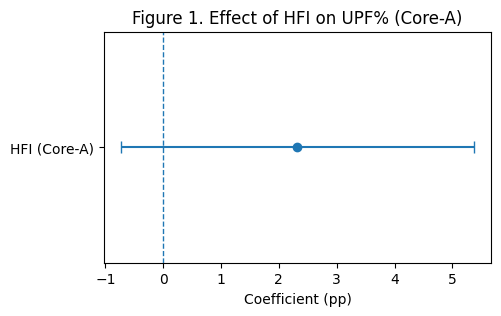

In [24]:
# Figure 1: Core-A 的 HFI 系数（pp）
# -------------------------
# ----- 绘图（coefplot） -----
# -------------------------
def _as_1d_numeric(x):
    """把标量/列表/Series/ndarray统一成1D float数组"""
    if isinstance(x, (list, tuple, pd.Series, np.ndarray)):
        return np.asarray(x, dtype=float).reshape(-1)
    return np.asarray([x], dtype=float)

def coefplot(ax, labels, est, lo, hi, title, xlabel="Coefficient (pp)"):
    est = _as_1d_numeric(est)
    lo  = _as_1d_numeric(lo)
    hi  = _as_1d_numeric(hi)
    assert len(est) == len(lo) == len(hi) == len(labels), "长度不一致"

    y = np.arange(len(labels))
    xerr = np.vstack([est - lo, hi - est])   # 形状(2, n)
    ax.errorbar(est, y, xerr=xerr, fmt='o', capsize=4)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()

fig, ax = plt.subplots(figsize=(5,3))
coefplot(ax, ["HFI (Core-A)"], est, ci[0], ci[1],
         title="Figure 1. Effect of HFI on UPF% (Core-A)")
plt.show()



# 3. Core-B 交互（HFI × 族裔三类；参考White）

In [25]:
# # 输出：各族裔下HFI边际效应 + 交互整体检验p值
form_coreB = (
    f"{y} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
    " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
)

# 为避免样本不同导致的差异，这里用“交互模型所需完整样本”
need_cols_B = coreA_cols  # 交互不增加额外主效应列
dat_coreB = df_model[need_cols_B].dropna().copy()
print(f"\nCore-B 样本量: {len(dat_coreB)}")
res_coreB = fit_ols(form_coreB, dat_coreB, cov_type="HC3")

# 计算各族裔下 HFI 的边际效应
groups = ["White", "Asian", "All other ethnicities"]
effects = []
for g in groups:
    if g == "White":
        combo = {"HFI_binary":1.0}  # 参考组无交互项
    else:
        combo = {"HFI_binary":1.0, f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{g}]":1.0}
    e, ci_g, p_g = linear_combo(res_coreB, combo)
    effects.append((g, e, ci_g, p_g))
    print(f"{g}: ΔUPF = {e:.2f} pp (95%CI {ci_g[0]:.2f}, {ci_g[1]:.2f}), p={p_g:.3f}")

p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")
print(f"交互整体检验 p-value = {p_inter:.3f}")


Core-B 样本量: 304
White: ΔUPF = 0.99 pp (95%CI -3.23, 5.22), p=0.644
Asian: ΔUPF = 2.16 pp (95%CI -2.92, 7.25), p=0.404
All other ethnicities: ΔUPF = 7.48 pp (95%CI -0.94, 15.90), p=0.082
交互整体检验 p-value = 0.405


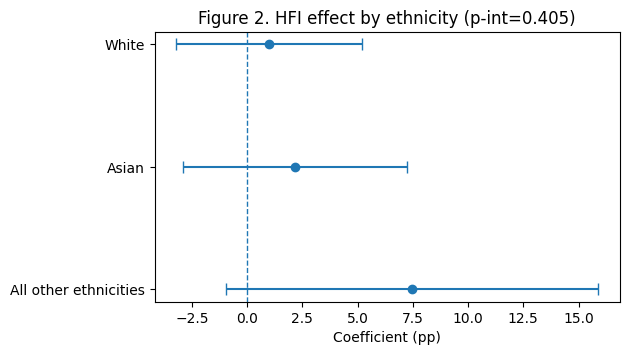

In [26]:
# Figure 2: 三族裔并列的边际效应图
fig2, ax2 = plt.subplots(figsize=(6,3.5))
labs = [g for g,_,_,_ in effects]
ests = [e for _,e,_,_ in effects]
los  = [ci[0] for _,_,ci,_ in effects]
his  = [ci[1] for _,_,ci,_ in effects]
coefplot(ax2, labs, ests, los, his, title=f"Figure 2. HFI effect by ethnicity (p-int={p_inter:.3f})")
plt.show()

# 4. Robustness（结构性混杂）：一次性加入 SES（income, employ）

In [30]:
# 报告：HFI 系数衰减百分比
# 同一样本比较 + 衰减百分比
# =========================================
ses_cols = coreA_cols + ["income", "employ"]
dat_R = df_model[ses_cols].dropna().copy()
print(f"\nRobustness(+SES) 样本量（统一样本）: {len(dat_R)}")

res_coreA_sameN = fit_ols(form_coreA, dat_R, cov_type="HC3")
res_ses         = fit_ols(form_coreA + " + income + C(employ)", dat_R, cov_type="HC3")

# --- 关键：用 get_term 取系数，兼容 ndarray/Series ---
b_core = get_term(res_coreA_sameN, "HFI_binary", np.nan)
b_ses  = get_term(res_ses,         "HFI_binary", np.nan)

ci_core_t = coef_ci(res_coreA_sameN, "HFI_binary")
ci_ses_t  = coef_ci(res_ses,         "HFI_binary")
ci_core = ci_core_t[1] if ci_core_t else (np.nan, np.nan)
ci_ses  = ci_ses_t[1]  if ci_ses_t  else (np.nan, np.nan)

atten = np.nan
if pd.notna(b_core) and not np.isclose(b_core, 0.0):
    atten = 100.0 * (b_core - b_ses) / abs(b_core)

print(f"HFI 系数：Core-A = {b_core:.2f} pp  →  +SES = {b_ses:.2f} pp；衰减 {atten:.1f}%")



Robustness(+SES) 样本量（统一样本）: 299
HFI 系数：Core-A = 2.75 pp  →  +SES = 3.34 pp；衰减 -21.3%


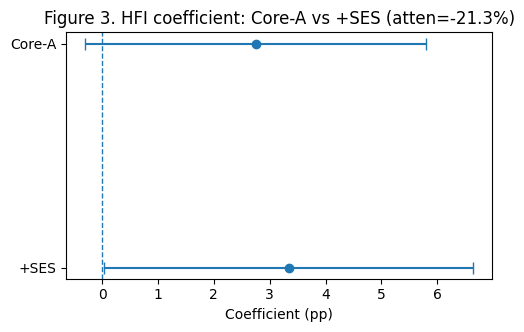

In [31]:
# ----- 绘图（Figure 3）-----
fig3, ax3 = plt.subplots(figsize=(5.5, 3.2))
coefplot(
    ax3,
    ["Core-A", "+SES"],
    [b_core, b_ses],
    [ci_core[0], ci_ses[0]],
    [ci_core[1], ci_ses[1]],
    title=f"Figure 3. HFI coefficient: Core-A vs +SES (atten={atten:.1f}%)"
)
plt.show()

# 5. Sensitivity（关键假设变化）

## 5.1 HFI 三分类(有序) + 趋势检验

In [32]:
# 期望已有列：HFI_category ∈ ["Food secure","Low food security","Very low food security"]
if "HFI_category" in df_model.columns:
    # 统一类型与顺序
    ord_dtype = pd.api.types.CategoricalDtype(
        categories=["Food secure","Low food security","Very low food security"], ordered=True
    )
    df_model["HFI_category"] = df_model["HFI_category"].astype(ord_dtype)

    sens_cols = coreA_cols + ["HFI_category"]
    dat_sens  = df_model[sens_cols].dropna().copy()
    print(f"\nSensitivity-有序三分类 样本量: {len(dat_sens)}")

    # (a) 类别模型（相对食品安全组）
    form_cat = (
        f"{y} ~ C(HFI_category, Treatment(reference='Food secure'))"
        " + age_participant + C(gender_participant)"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_cat = fit_ols(form_cat, dat_sens, cov_type="HC3")
    for lev in ["Low food security","Very low food security"]:
        term = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
        est, ci, p = coef_ci(res_cat, term)
        print(f"{lev}: {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")

    # (b) 趋势检验（0,1,2 连续）
    tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
    dat_sens["HFI_trend"] = dat_sens["HFI_category"].map(tr_map).astype(float)
    form_trend = (
        f"{y} ~ HFI_trend"
        " + age_participant + C(gender_participant)"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_trend = fit_ols(form_trend, dat_sens, cov_type="HC3")
    est, ci, p = coef_ci(res_trend, "HFI_trend")
    print(f"p-trend: 每增加一档HFI，UPF% 变化 {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")
else:
    print("\n[跳过] 未找到 HFI_category（三分类）列，已跳过敏感性-三分类与趋势检验。")



Sensitivity-有序三分类 样本量: 304
Low food security: 0.87 pp (95%CI -3.11, 4.85), p=0.668
Very low food security: 3.80 pp (95%CI -0.06, 7.65), p=0.055
p-trend: 每增加一档HFI，UPF% 变化 1.75 pp (95%CI -0.11, 3.60), p=0.066


## 5.2 探索性交互：HFI × I(child_numbers≥3) （附录）

In [33]:
df_model["many_children"] = (df_model["child_numbers"] >= 3).astype("int")
cols_c3 = coreA_cols + ["many_children"]
dat_c3  = df_model[cols_c3].dropna().copy()
form_c3 = (
    f"{y} ~ HFI_binary + many_children + HFI_binary:many_children"
    " + age_participant + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
res_c3 = fit_ols(form_c3, dat_c3, cov_type="HC3")
e, ci, p = coef_ci(res_c3, "HFI_binary:many_children")
print(f"[探索] HFI×(≥3个孩子) 交互 = {e:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}), p={p:.3f}")


[探索] HFI×(≥3个孩子) 交互 = 0.37 pp (95%CI -6.06, 6.79), p=0.911


## 5.3 族裔复核交互方向（附录）

In [35]:
# ============ 附录：族裔交互方向复核（仅三类） ============
# 目标：核对各组 HFI 边际效应方向 & 成对比较
# ============================================================

# ----- 保证与 Core-B 同样本 -----
need_cols_B = [y, "HFI_binary", "age_participant", "gender_participant",
               "ethn_participant", "child_numbers"]
dat_coreB = df_model[need_cols_B].dropna().copy()
print(f"[Appendix] 样本量（与Core-B一致）: {len(dat_coreB)}")

# ----- 重新拟合交互模型（参考组=White） -----
form_coreB = (
    f"{y} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
    " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
)
res_coreB = fit_ols(form_coreB, dat_coreB, cov_type="HC3")

# ----- 各组 HFI 边际效应（pp） -----
groups = ["White", "Asian", "All other ethnicities"]
appendix_eff = []
for g in groups:
    if g == "White":
        combo = {"HFI_binary": 1.0}
    else:
        combo = {
            "HFI_binary": 1.0,
            f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{g}]": 1.0
        }
    est_g, ci_g, p_g = linear_combo(res_coreB, combo)
    appendix_eff.append((g, est_g, ci_g[0], ci_g[1], p_g))

print("\n[各族裔组 HFI 边际效应]（pp）")
for g, e, lo, hi, p in appendix_eff:
    print(f"- {g:>22}: {e:.2f}  (95%CI {lo:.2f}, {hi:.2f}), p={p:.3f}")

# ----- 交互整体检验 -----
p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")
print(f"\n[交互整体检验] p-int = {p_inter:.3f}")

# ----- 成对比较：效应差（组A - 组B） -----
def pair_diff(result, A, B):
    """差值 = Effect_A - Effect_B"""
    # White 的效应是 b_HFI；其他组是在此基础上 + 各自交互项
    termA = f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{A}]"
    termB = f"HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.{B}]"
    combo = {}
    if A != "White": combo[termA] = 1.0
    if B != "White": combo[termB] = -1.0
    # White 的主效应在差分中抵消，无需显式加入 HFI_binary
    # （若 A/B 含 White，则只保留另一个组的交互项）
    return linear_combo(result, combo if combo else {"HFI_binary":0.0})

pairs = [("Asian","White"), ("All other ethnicities","White"), ("Asian","All other ethnicities")]
pair_rows = []
print("\n[成对比较：效应差（组A - 组B）]  单位：pp")
for A,B in pairs:
    est_d, ci_d, p_d = pair_diff(res_coreB, A, B)
    print(f"- {A:>22}  -  {B:<22}:  {est_d:.2f}  (95%CI {ci_d[0]:.2f}, {ci_d[1]:.2f}), p={p_d:.3f}")
    pair_rows.append((A, B, est_d, ci_d[0], ci_d[1], p_d))

[Appendix] 样本量（与Core-B一致）: 304

[各族裔组 HFI 边际效应]（pp）
-                  White: 0.99  (95%CI -3.23, 5.22), p=0.644
-                  Asian: 2.16  (95%CI -2.92, 7.25), p=0.404
-  All other ethnicities: 7.48  (95%CI -0.94, 15.90), p=0.082

[交互整体检验] p-int = 0.405

[成对比较：效应差（组A - 组B）]  单位：pp
-                  Asian  -  White                 :  1.17  (95%CI -5.33, 7.67), p=0.725
-  All other ethnicities  -  White                 :  6.49  (95%CI -2.96, 15.94), p=0.178
-                  Asian  -  All other ethnicities :  -5.32  (95%CI -15.22, 4.58), p=0.292


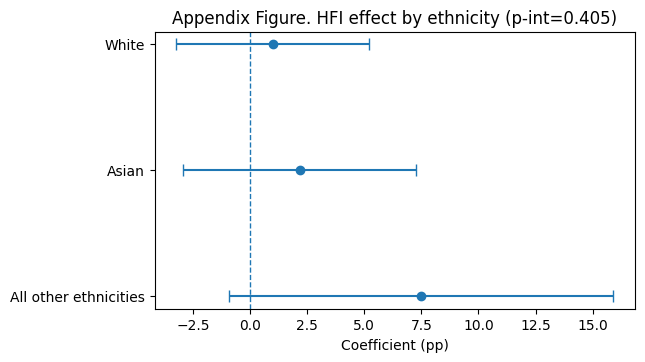

In [36]:
# ----- 附录图：三组边际效应并列 -----
labs_e = [r[0] for r in appendix_eff]
ests_e = [r[1] for r in appendix_eff]
los_e  = [r[2] for r in appendix_eff]
his_e  = [r[3] for r in appendix_eff]

figA, axA = plt.subplots(figsize=(6.2, 3.6))
coefplot(axA, labs_e, ests_e, los_e, his_e,
         title=f"Appendix Figure. HFI effect by ethnicity (p-int={p_inter:.3f})")
plt.show()

# 6. Table 1（描述性摘要）

In [37]:
def table1(df):
    out = {}
    # 年龄
    out["Age (years), mean ± SD"] = f"{df['age_participant'].mean():.2f} ± {df['age_participant'].std():.2f}"
    # 性别分布
    gdist = df["gender_participant"].value_counts(dropna=False, normalize=True).rename(lambda x: f"Gender: {x}")
    for k, v in gdist.items():
        out[k] = f"{v*100:.1f}%"
    # 族裔三类分布
    edist = df["ethn_participant"].value_counts(dropna=False, normalize=True)
    for k, v in edist.items():
        label = "Missing" if pd.isna(k) else k
        out[f"Ethnicity ({label})"] = f"{v*100:.1f}%"
    # HFI 流行率
    if "HFI_binary" in df.columns:
        hfi_prev = df["HFI_binary"].mean()*100
        out["HFI prevalence"] = f"{hfi_prev:.1f}%"
    # 各族裔UPF原始均值（简版）
    m = df.groupby("ethn_participant")[y].mean().round(2)
    for k, v in m.items():
        out[f"UPF% mean - {k}"] = f"{v:.2f}"
    # 汇总为一列表
    return pd.DataFrame({"Value": pd.Series(out)})

t1_df = table1(df_model[coreA_cols])
print("\nTable 1（主样本，含三类族裔）:")
display(t1_df)


Table 1（主样本，含三类族裔）:


/tmp/ipython-input-1411111733.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m = df.groupby("ethn_participant")[y].mean().round(2)


,Value
"Age (years), mean ± SD",6.90 ± 2.59
Gender: 1,51.0%
Gender: 2,49.0%
Ethnicity (White),54.9%
Ethnicity (Asian),32.5%
Ethnicity (All other ethnicities),12.7%
HFI prevalence,31.5%
UPF% mean - White,71.80
UPF% mean - Asian,66.12
UPF% mean - All other ethnicities,67.55


# 7. 导出关键结果

In [44]:
# =========================================
# ===== 论文版·精简关键结果（CSV） =====
# =========================================
import os, numpy as np, pandas as pd

out_dir = "/content/drive/MyDrive/UPF-HFI/Model/output"
os.makedirs(out_dir, exist_ok=True)

rnd_coef = 2   # 系数/CI 保留小数
rnd_p    = 3   # p值保留小数

# ---- 主表（Table X）：Core-A + 交互整体 + +SES稳健性 ----
# Core-A headline
hfi_core = coef_ci(res_coreA, "HFI_binary")
coreA_row = {
    "Section": "Core-A (main)",
    "Outcome": "UPF%",
    "N": len(dat_coreA),
    "HFI_coef_pp": round(hfi_core[0], rnd_coef),
    "CI_lo": round(hfi_core[1][0], rnd_coef),
    "CI_hi": round(hfi_core[1][1], rnd_coef),
    "p": round(hfi_core[2], rnd_p)
}

# 交互整体（p-int）
inter_row = {
    "Section": "Interaction (Core-B)",
    "Outcome": "UPF%",
    "N": len(dat_coreB),
    "HFI_coef_pp": np.nan,
    "CI_lo": np.nan,
    "CI_hi": np.nan,
    "p": round(p_inter, rnd_p),
    "Note": "p-interaction across 3 ethnic groups"
}

# +SES 稳健性（同一样本对比 & 衰减）
rob_row_core = {
    "Section": "Robustness",
    "Outcome": "UPF%",
    "N": len(dat_R),
    "Model": "Core-A (same N)",
    "HFI_coef_pp": round(b_core, rnd_coef),
    "CI_lo": round(ci_core[0], rnd_coef),
    "CI_hi": round(ci_core[1], rnd_coef),
    "p": np.nan
}
rob_row_ses = {
    "Section": "Robustness",
    "Outcome": "UPF%",
    "N": len(dat_R),
    "Model": "Core-A + SES (income, employment)",
    "HFI_coef_pp": round(b_ses, rnd_coef),
    "CI_lo": round(ci_ses[0], rnd_coef),
    "CI_hi": round(ci_ses[1], rnd_coef),
    "attenuation_pct": round(atten, 1),
    "p": np.nan
}

paper_main = pd.DataFrame([coreA_row, inter_row, rob_row_core, rob_row_ses])
main_path = f"{out_dir}/paper_table_main.csv"
paper_main.to_csv(main_path, index=False)

# ---- 附录表（Appendix）：各族裔组的 HFI 边际效应 ----
ethn = [e[0] for e in effects]
paper_appx = pd.DataFrame({
    "Ethnicity": ethn,
    "N_group": [dat_coreB.query("ethn_participant == @g").shape[0] for g in ethn],
    "HFI_effect_pp": [round(e[1], rnd_coef) for e in effects],
    "CI_lo": [round(e[2][0], rnd_coef) for e in effects],
    "CI_hi": [round(e[2][1], rnd_coef) for e in effects],
    "p": [round(e[3], rnd_p) for e in effects],
    "p_interaction_overall": round(p_inter, rnd_p)
})
appx_path = f"{out_dir}/paper_table_appendix_ethnicity.csv"
paper_appx.to_csv(appx_path, index=False)

print("已导出：")
print("  -", main_path)
print("  -", appx_path)


已导出：
  - /content/drive/MyDrive/UPF-HFI/Model/output/paper_table_main.csv
  - /content/drive/MyDrive/UPF-HFI/Model/output/paper_table_appendix_ethnicity.csv
